<a href="https://colab.research.google.com/github/41371115h-dot/114-class-thursday2-4/blob/main/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80%E4%BD%9C%E6%A5%AD%E4%BA%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install gradio pandas requests folium geopy google-generativeai -q

import requests
import pandas as pd
import gradio as gr
import random
import folium
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time

geolocator = Nominatim(user_agent="tourist_spot_recommender_v2")

def get_coordinates(location_name):
    try:
        location = geolocator.geocode(f"{location_name}, Taiwan", timeout=10)
        if location:
            return (location.latitude, location.longitude)
        return None
    except Exception as e:
        print("geocode error:", e)
        return None

# try to resolve a readable name for elements lacking 'name'
def resolve_name_from_tags(tags):
    # priority list of tag keys that might contain human-friendly name
    for key in ("name", "alt_name", "official_name", "short_name", "operator", "brand", "description"):
        v = tags.get(key)
        if v:
            return v
    return None

# reverse geocode fallback (rate-limited usage — only call for a few items)
def reverse_name(lat, lon):
    try:
        time.sleep(1)  # be gentle to Nominatim
        r = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if r and r.address:
            # return the first part (often the POI name or street)
            return r.address.split(",")[0]
    except Exception as e:
        print("reverse geocode error:", e)
    return None

def fetch_attractions(lat, lon, radius=2000, max_reverse=6):
    """
    Fetch nodes/ways/relations with tourism or leisure tags.
    Improvements:
    - include ways/relations
    - resolve missing names via tags or limited reverse geocoding
    - compute actual distance and bucket it
    """
    query = f"""
    [out:json][timeout:25];
    (
      node["tourism"](around:{radius},{lat},{lon});
      way["tourism"](around:{radius},{lat},{lon});
      relation["tourism"](around:{radius},{lat},{lon});
      node["leisure"](around:{radius},{lat},{lon});
      way["leisure"](around:{radius},{lat},{lon});
      relation["leisure"](around:{radius},{lat},{lon});
    );
    out center;
    """
    url = "https://overpass-api.de/api/interpreter"
    try:
        resp = requests.post(url, data={'data': query}, timeout=40)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        print("Overpass error:", e)
        return pd.DataFrame()

    items = []
    reverse_calls = 0
    for el in data.get("elements", []):
        tags = el.get("tags", {}) or {}
        # For way/relation, coordinates in 'center'; for node, use lat/lon
        if el.get("type") in ("way", "relation"):
            cent = el.get("center") or {}
            lat_el = cent.get("lat")
            lon_el = cent.get("lon")
        else:
            lat_el = el.get("lat")
            lon_el = el.get("lon")

        if lat_el is None or lon_el is None:
            continue

        name = resolve_name_from_tags(tags)
        if not name:
            # attempt limited reverse geocoding (avoid many calls)
            if reverse_calls < max_reverse:
                rname = reverse_name(lat_el, lon_el)
                reverse_calls += 1
                if rname:
                    name = rname

        if not name:
            name = "（未命名 - 附近地點）"  # still avoid totally blank string

        # determine type: prefer tourism tag, then leisure, else '未知'
        typ = tags.get("tourism") or tags.get("leisure") or "未知"

        # compute real distance in meters to center
        try:
            dist_m = geodesic((lat, lon), (lat_el, lon_el)).meters
        except Exception:
            dist_m = None

        # bucket distance: 近 <500m, 中 500-1500m, 遠 >1500m
        if dist_m is None:
            dist_bucket = "未知"
        elif dist_m <= 500:
            dist_bucket = "近"
        elif dist_m <= 1500:
            dist_bucket = "中"
        else:
            dist_bucket = "遠"

        items.append({
            "景點名稱": name,
            "類型": typ,
            "地址": tags.get("addr:street", ""),
            "熱門程度": random.choice(['熱門', '中等', '小眾']),
            "是否免費": random.choice(['是', '否']),
            "距離_m": int(dist_m) if dist_m is not None else None,
            "距離": dist_bucket,
            "是否適合拍照": random.choice(['是', '否']),
            "特色描述": tags.get("description") or random.choice(['景色優美', '文化氣息濃厚', '適合情侶約會', '小孩友善', '拍照超美']),
            "經度": lon_el,
            "緯度": lat_el
        })

    df = pd.DataFrame(items)
    # drop duplicates by name+coords
    if not df.empty:
        df = df.drop_duplicates(subset=["景點名稱", "經度", "緯度"]).reset_index(drop=True)
    print(f"✅ Overpass 回傳 {len(df)} 筆候選景點（其中已使用有限 reverse geocode）")
    return df

def safe_list(xs):
    if xs is None:
        return []
    # Gradio's CheckboxGroup returns list; ensure list
    return list(xs)

def filter_and_recommend(df, type_filter, distance_filter, is_free, is_photo):
    # defensive checks
    if df is None or df.empty:
        return pd.DataFrame(), "此地區沒有找到景點。", ""

    # if user didn't select any type, treat as all types
    type_list = safe_list(type_filter)
    if len(type_list) == 0:
        type_list = df['類型'].unique().tolist()

    distance_list = safe_list(distance_filter)
    if len(distance_list) == 0:
        distance_list = df['距離'].unique().tolist()

    free_list = ['是'] if is_free else ['是', '否']
    photo_list = ['是'] if is_photo else ['是', '否']

    # ensure the values' case/format matches df: many typ tags like 'viewpoint' etc
    filtered = df[
        df['類型'].isin(type_list) &
        df['距離'].isin(distance_list) &
        df['是否免費'].isin(free_list) &
        df['是否適合拍照'].isin(photo_list)
    ].copy()

    if filtered.empty:
        # try fallback: ignore type filter if it's too restrictive
        fallback = df[
            df['距離'].isin(distance_list) &
            df['是否免費'].isin(free_list) &
            df['是否適合拍照'].isin(photo_list)
        ].copy()
        if not fallback.empty:
            filtered = fallback
        else:
            return pd.DataFrame(), "沒有找到符合條件的景點。請嘗試放寬篩選條件。", ""

    n_recommend = min(3, len(filtered))
    recommended = filtered.sample(n=n_recommend, replace=False)

    recommend_list = "\n".join([
        f"{i+1}. {row['景點名稱']}（{row['類型']} / {row['距離']} / 距離 {row['距離_m']} m） - {row['特色描述']}"
        for i, row in recommended.iterrows()
    ])

    ai_input = "、".join([
        f"{row['景點名稱']}，類型{row['類型']}，距離{row['距離']}，特色：{row['特色描述']}"
        for _, row in recommended.iterrows()
    ])

    return recommended, recommend_list, ai_input

def generate_summary(ai_input):
    if not ai_input:
        return "請先產生景點清單。"
    parts = ai_input.split("、")
    if len(parts) == 1:
        return f"建議首選：{parts[0]}。"
    return f"🌟 建議行程：先去 {parts[0]}（拍照/打卡不錯），之後可前往 {parts[1]} 感受當地氛圍。"

def search_and_recommend(location_name, type_filter, distance_filter, is_free, is_photo, radius_km=2):
    # defensive
    if not location_name or str(location_name).strip()=="":
        return pd.DataFrame(), "請輸入搜尋地點（例如：台北車站）", "", "沒有地圖"

    coords = get_coordinates(location_name)
    if not coords:
        return pd.DataFrame(), "無法取得地點座標，請確認地名（多試幾個寫法）", "", "沒有地圖"

    lat, lon = coords
    # fetch with radius in meters
    df = fetch_attractions(lat, lon, radius=int(radius_km*1000))
    if df.empty:
        return pd.DataFrame(), "此地區找不到景點（或 Overpass API 忙碌）", "（無建議）", "沒有地圖"

    recommended_df, recommend_list, ai_input = filter_and_recommend(df, type_filter, distance_filter, is_free, is_photo)
    ai_summary = generate_summary(ai_input)

    # build map - if no recs, still show center map
    map_obj = folium.Map(location=[lat, lon], zoom_start=14)
    try:
        if not recommended_df.empty:
            for _, row in recommended_df.iterrows():
                folium.Marker(
                    [row["緯度"], row["經度"]],
                    popup=f"{row['景點名稱']}（{row['類型']} / {row['距離']}）",
                    tooltip=row["特色描述"],
                    icon=folium.Icon(color="blue", icon="info-sign")
                ).add_to(map_obj)
        else:
            folium.Marker([lat, lon], popup="搜尋中心", tooltip=location_name).add_to(map_obj)
    except Exception as e:
        print("map plotting error:", e)

    # prepare output table columns
    if not recommended_df.empty:
        out_table = recommended_df[['景點名稱', '類型', '距離', '距離_m']].reset_index(drop=True)
    else:
        out_table = pd.DataFrame(columns=["景點名稱", "類型", "距離", "距離_m"])

    return out_table, recommend_list or "（無推薦清單）", ai_summary, map_obj._repr_html_()

# ---------------- Gradio UI ----------------
with gr.Blocks(title="觀光景點推薦系統（修正版）") as demo:
    gr.Markdown("# 🧭 觀光景點推薦器（修正版）\n輸入地點 → 篩選 → 推薦景點並顯示地圖")

    with gr.Row():
        location_input = gr.Textbox(label="搜尋地點（例：台北車站、九份）", value="台北101")
        # 類型選項：留下一些常見 OSM tourism/leisure tags
        type_select = gr.CheckboxGroup(['viewpoint','park','museum','theme_park','attraction','artwork','historic','temple','zoo'],
                                       label="景點類型（可不選為全部）", value=['viewpoint','park'])
        distance_select = gr.CheckboxGroup(['近', '中', '遠'], label="距離範圍（近 <500m / 中 500-1500m / 遠 >1500m）", value=['近','中'])
        free_toggle = gr.Checkbox(label="只看免費景點", value=False)
        photo_toggle = gr.Checkbox(label="只看適合拍照", value=True)
        search_btn = gr.Button("🔎 搜尋並推薦")

    output_table = gr.DataFrame(headers=["景點名稱","類型","距離","距離_m"])
    output_text = gr.Textbox(label="推薦清單")
    output_summary = gr.Textbox(label="AI 建議")
    output_map = gr.HTML(label="互動地圖")

    def main_wrapper(location, type_, distance, free, photo):
        try:
            table, text, summary, map_html = search_and_recommend(location, type_, distance, free, photo)
            return table, text, summary, map_html
        except Exception as e:
            print("wrapper error:", e)
            return pd.DataFrame(), "系統發生錯誤，請查看日誌。", "", "沒有地圖"

    search_btn.click(fn=main_wrapper,
                     inputs=[location_input, type_select, distance_select, free_toggle, photo_toggle],
                     outputs=[output_table, output_text, output_summary, output_map])

if __name__ == "__main__":
    demo.launch(inbrowser=True)


### **畫面顯示**

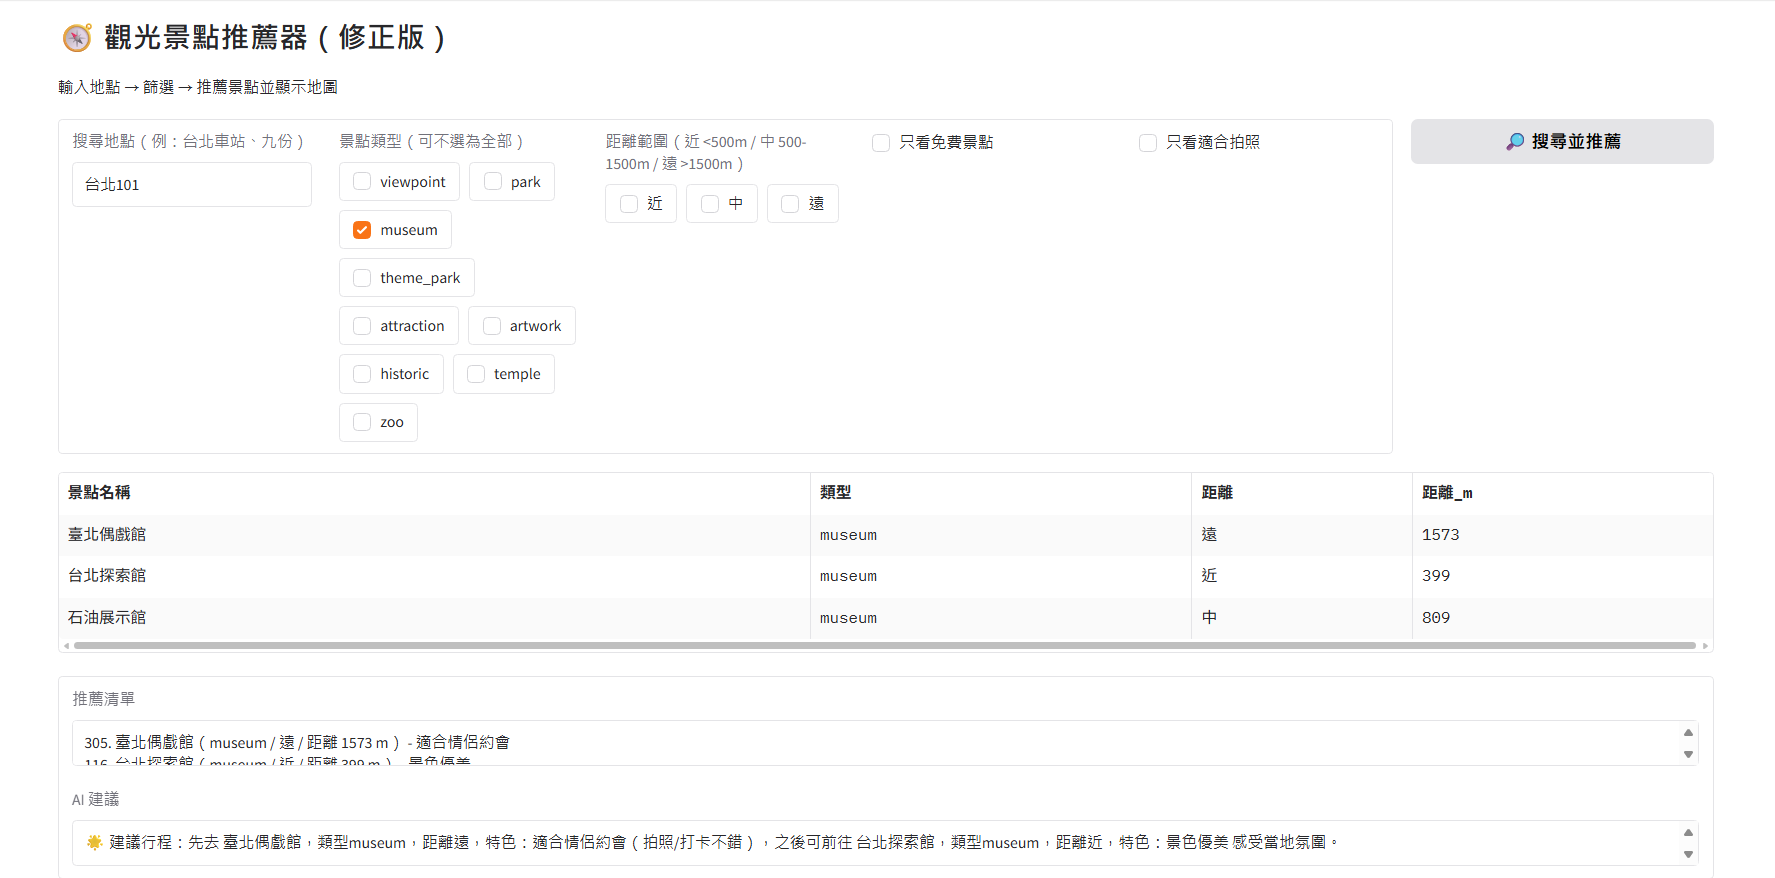

## **地圖**

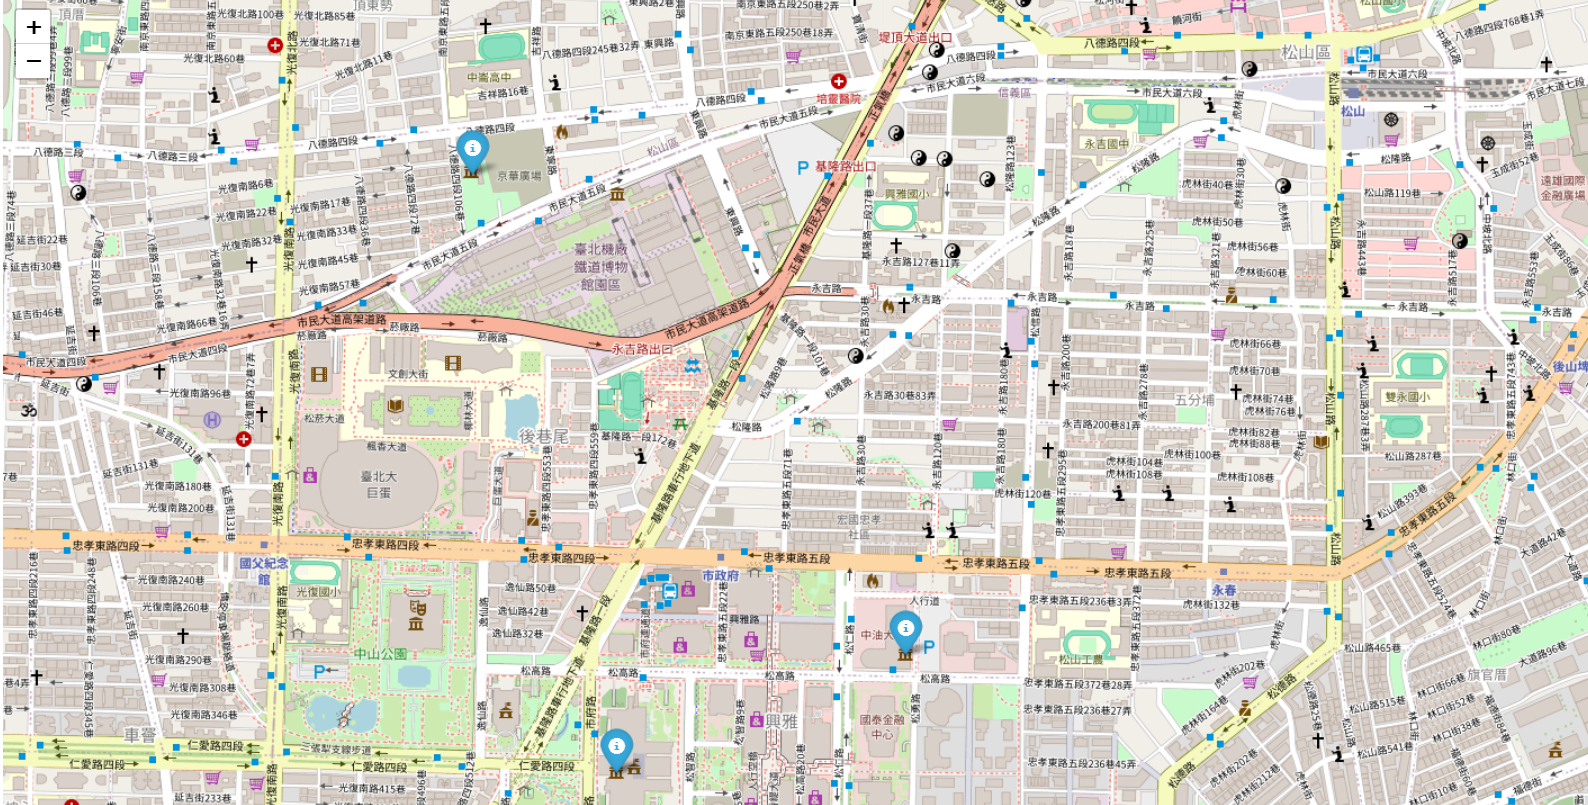